# Full data analysis: frame sums and XGM, standard processing, normalized processing

This notebook summarises several aspects of data analysis. Its main purpose is to demonstrate the possibility to select desired frames based on frame sum. Processing is *not* explained inside the notebook in detail. Please refer to the other notebooks for more in depth explanations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import euxfel_scs_tools as scs
import extra_data as ed
import extra_geom as eg
import toolbox_scs.detectors as tbdet

In [2]:
import xarray as xr
xr.set_options(display_style='text')

In [3]:
proposal = 2530  # proposal number
run = 108  # run number
dark_run = 111

pattern = ['image', 'dark'] * 100
dirname = 'processed_runs_xgm_sel'

## XGM

In [4]:
scs.reduction_std(proposal=proposal, run=dark_run, pattern=pattern, dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [5]:
scs.reduction_sum_bg_sub(proposal=proposal, run=run, pattern=pattern, dark_run=dark_run, dirname=dirname,
                         frames={'image': 'image',
                                 'dark': 'dark'},
                         dark_run_frames={'image': 'image',
                                          'dark': 'dark'},
                         trains=None, njobs=40)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [6]:
image_sum, xgm = scs.read(dirname=dirname, run=run, reduction_type='sum_bg_sub', dataset='image_sum')

Averaged summed intensity: 22277.673647752654


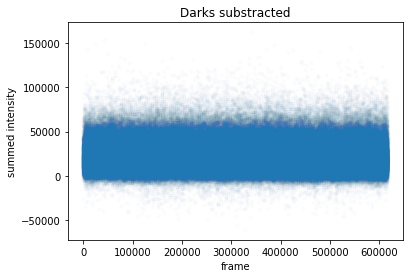

In [7]:
detector_sum = np.sum(image_sum, axis=0);
plt.plot(detector_sum, '.', alpha=0.01)
plt.xlabel('frame')
plt.ylabel('summed intensity')
plt.title('Darks substracted')
print('Averaged summed intensity:', np.mean(detector_sum.data))

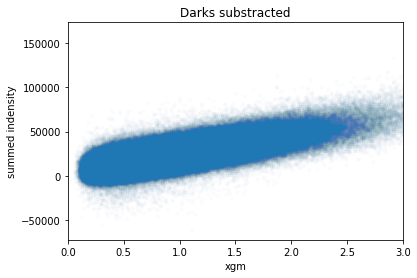

In [8]:
plt.plot(xgm, detector_sum, '.', alpha=0.01)
plt.xlabel('xgm')
plt.ylabel('summed indensity')
plt.xlim((0,3))
plt.title('Darks substracted');

## Standard processing

To specify only selected frames we can pass a 2d array-like `frame_sel` of type `bool` to `reduction_std`. It is used to process only those image frames `i` in train `t` where `frame_sel[t][i]=True`. Suppose, we want to use all frames where the dark-substracted pixel sum is > 0:

In [9]:
scs.reduction_std(proposal=proposal, run=run, pattern=pattern,
                  frame_sel=(detector_sum.data > 0).reshape(-1,100).tolist(), dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [10]:
image_std = scs.read(dirname=dirname, run=run, reduction_type='std', dataset='image_std')
dark_std = scs.read(dirname=dirname, run=run, reduction_type='std', dataset='dark_std')

In [11]:
dr_image_std = scs.read(dirname=dirname, run=dark_run, reduction_type='std', dataset='image_std')
dr_dark_std = scs.read(dirname=dirname, run=dark_run, reduction_type='std', dataset='dark_std')

In [12]:
image_std = (np.mean(image_std, axis=0) - np.mean(dark_std, axis=0) -
            (np.mean(dr_image_std, axis=0) - np.mean(dr_dark_std, axis=0)))

In [13]:
quad_pos = [(-123.0 , 1.72),  # TR
            (-130.0, -110.18),  # BR
            (1.4, -122.78),  # BL
            (2.2, -4.08)]  # TL

geopath = '/gpfs/exfel/sw/software/git/EXtra-geom/docs/dssc_geo_june19.h5'
geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

masklist = [(4, 1, 0),
            (13, 0, 0),
            (1, 0, 6)]

dssc_mask = tbdet.quickmask_DSSC_ASIC(geom, masklist)

image, center = geom.position_modules_fast(image_std)

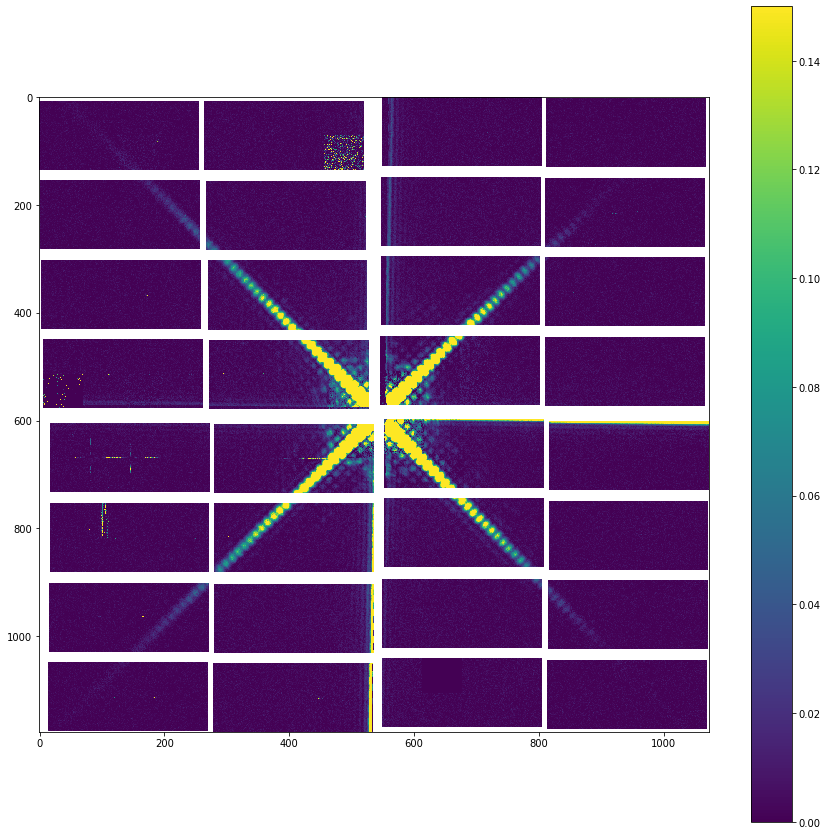

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
plt.imshow(image, vmin=0, vmax=0.15, aspect=204.0/236.0)
plt.colorbar()

## Normalised processing

To specify only selected frames we can pass a 2d array-like `frame_sel` of type `bool` to `reduction_norm`. It is used to process only those image frames `i` in train `t` where `frame_sel[t][i]=True`. Suppose we want to use all frames with 0 < pixel_sum < 50000:

In [15]:
scs.reduction_norm(proposal=proposal, run=run, pattern=pattern, dark_run=dark_run,
                   xgm_threshold=(0.2, 2.2), dirname=dirname,
                   frame_sel=np.logical_and(detector_sum.data > 0,
                                            detector_sum.data < 50000).reshape(-1,100).tolist())

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


In [16]:
image_norm = scs.read(dirname=dirname, run=run, reduction_type='norm', dataset='image_norm')

In [17]:
image_norm_average = np.mean(image_norm, axis=0)

In [18]:
quad_pos = [(-123.0 , 1.72),  # TR
            (-130.0, -110.18),  # BR
            (1.4, -122.78),  # BL
            (2.2, -4.08)]  # TL

geopath = '/gpfs/exfel/sw/software/git/EXtra-geom/docs/dssc_geo_june19.h5'
geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

masklist = [(4, 1, 0),
            (13, 0, 0),
            (1, 0, 6)]

dssc_mask = tbdet.quickmask_DSSC_ASIC(geom, masklist)

image, center = geom.position_modules_fast(image_norm_average)

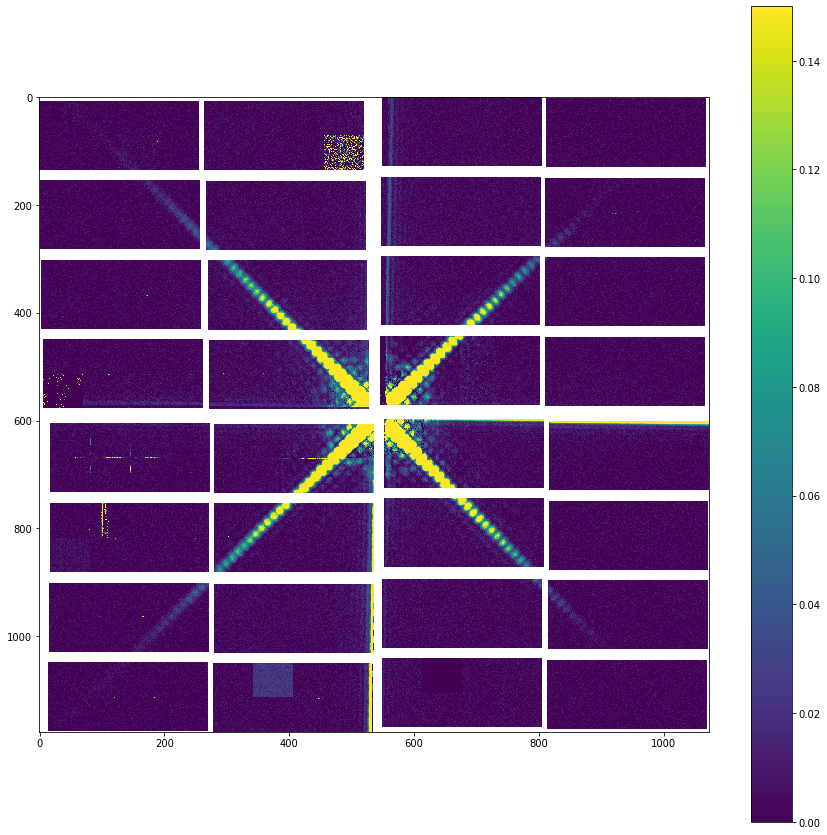

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
plt.imshow(image, vmin=0, vmax=0.15, aspect=204.0/236.0)
plt.colorbar()